### Differential Voltage Analysis (DVA) Script

**Author:** Karla Negrete  
**Version:** 1.0  
**Last Edited:** 2025-05-04  
**Contact:** [kn583@drexel.edu](mailto:kn583@drexel.edu)

**Purpose:** Analyze differential voltage (dV/dQ) curves during charge/discharge to study degradation in Li-ion cells. Focus is on identifying capacity fade mechanisms such as loss of lithium inventory (LLI) and loss of active material (LAM). LLI is tracked via voltage slippage.

**Data:** Full-cell cycling data (C/20) from NMC532/graphite cells at cycles 3, 54, 105, 156, 207, 258, and 309. Complementary half-cell data (graphite and NMC532, C/20) used to construct synthetic full-cell curves.


1. Installing necessary packages

In [2]:
!pip install --quiet numpy>=1.22.2 \
                   pandas>=1.4.2 \
                   matplotlib>=3.5.1 \
                   scipy>=1.8.0 \
                   scikit-learn>=1.0.2



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


2. Import packages

In [4]:
import numpy as np
import re
import pandas as pd
import itertools
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

3. Establish user-made functions required 

In [6]:
def rmse(params: tuple[float, float, float, float],
         cathode_df: pd.DataFrame,
         anode_df: pd.DataFrame,
         exp_df: pd.DataFrame) -> float:
    """
    Compute the root mean squared error (RMSE) between the synthetic full-cell 
    dV/dQ curve and experimental full-cell data

    Parameters:
    - params (tuple): a tuple containing four parameters:
        c_wt (float): initial weight of the cathode
        a_wt (float): initial weight of the anode
        c_off (float): Q offset for cathode capacity
        a_off (float): Q offset for anode capacity
    - cathode_df (pd.DataFrame): df of half-cell data for cathode
    - anode_df (pd.DataFrame): df of half-cell data for anode
    - exp_df (pd.DataFrame): df of experimental full-cell data 

    Returns:
    - float: RMSE value between synthetic and experimental dV/dQ curves.
    """
    
    # Extract capacity values starting from mAh >= 0.5
    x_new_idx = exp_df[exp_df['mAh'] >= 0.5].index[0]
    x_new = exp_df['mAh'].iloc[x_new_idx:].reset_index(drop=True)

    # Unpack parameter tuple
    c_wt, a_wt, c_off, a_off = params

    # Apply weights and offsets to cathode and anode data
    Q_cath = cathode_df['mAhg'] * c_wt + c_off
    Q_anod = anode_df['mAhg'] * a_wt + a_off

    # Shared capacity axis
    x_shared_trim = np.linspace(x_new.min(), exp_df['mAh'].max(), 500)

    # Interpolate voltages and compute dV/dQ for cathode and anode
    V_cath_trim = np.interp(x_shared_trim, Q_cath, cathode_df['volts'])
    V_anod_trim = np.interp(x_shared_trim, Q_anod, anode_df['volts'])
    dvdQ_cath_trim = np.gradient(V_cath_trim, x_shared_trim)
    dVdQ_anod_trim = np.gradient(V_anod_trim, x_shared_trim)

    # Synthetic full-cell dV/dQ
    dVdQ_syn = dvdQ_cath_trim - dVdQ_anod_trim

    # Interpolate experimental voltage and compute dV/dQ
    V_data_interp = np.interp(x_shared_trim, exp_df['mAh'], exp_df['volts'])
    dVdQ_data = np.gradient(V_data_interp, x_shared_trim)

    # Compute RMSE
    rmse = mean_squared_error(dVdQ_data, dVdQ_syn, squared=False)

    return rmse

In [7]:
def test_params(params: tuple[float, float, float, float],
                cathode_data: pd.DataFrame,
                anode_data: pd.DataFrame,
                exp_data: pd.DataFrame,
                name: str,
                trim: float,
                plot: bool = False) -> tuple[float, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Compare synthetic full-cell voltage and dV/dQ curves to experimental data, and optionally plot results.

    Parameters:
    - params (tuple): a tuple containing four parameters:
        c_wt (float): initial weight of the cathode
        a_wt (float): initial weight of the anode
        c_off (float): Q offset for cathode capacity
        a_off (float): Q offset for anode capacity
    - cathode_df (pd.DataFrame): df of half-cell data for cathode
    - anode_df (pd.DataFrame): df of half-cell data for anode
    - exp_df (pd.DataFrame): df of experimental full-cell data 
    - name (str): title for plots
    - trim (float): cutoff point in mAh to begin analysis
    - plot (bool): whether to display plots (default False)

    Returns:
    - tuple: (rmse in mV, V_full_syn, V_data_interp, dVdQ_syn, dVdQ_data, x_shared_trim, dvdQ_cath_trim, dVdQ_anod_trim)
    """

    # Unpack parameters
    c_wt, a_wt, c_off, a_off = params

    # Apply weight and offset to electrodes
    Q_cath = cathode_data['mAhg'] * c_wt + c_off
    Q_anod = anode_data['mAhg'] * a_wt + a_off

    # Trim experimental data starting at specified capacity
    x_new_idx = exp_data[exp_data['mAh'] >= trim].index[0]
    x_new = exp_data['mAh'].iloc[x_new_idx:].reset_index(drop=True)
    x_shared_trim = np.linspace(x_new.min(), exp_data['mAh'].max(), 500)

    # Interpolate voltage data and compute gradients
    V_cath_trim = np.interp(x_shared_trim, Q_cath, cathode_data['volts'])
    V_anod_trim = np.interp(x_shared_trim, Q_anod, anode_data['volts'])
    dvdQ_cath_trim = np.gradient(V_cath_trim, x_shared_trim)
    dVdQ_anod_trim = np.gradient(V_anod_trim, x_shared_trim)

    # Synthetic full-cell voltage and dV/dQ
    V_full_syn = V_cath_trim - V_anod_trim
    dVdQ_syn = dvdQ_cath_trim - dVdQ_anod_trim

    # Experimental voltage and dV/dQ
    V_data_interp = np.interp(x_shared_trim, exp_data['mAh'], exp_data['volts'])
    dVdQ_data = np.gradient(V_data_interp, x_shared_trim)

    # Compute RMSE between synthetic and experimental voltage curves
    rmse = mean_squared_error(V_data_interp, V_full_syn, squared=False)

    # Plotting (if requested)
    if plot:
        # Voltage comparison
        plt.plot(x_shared_trim, V_full_syn, label='Synthetic', color='purple')
        plt.plot(x_shared_trim, V_data_interp, label='Experimental', color='pink')
        plt.title(f'Voltage Curve - {name}')
        plt.xlabel('Q (mAh)')
        plt.ylabel('V')
        plt.legend()
        plt.show()

        # dV/dQ comparison
        plt.plot(x_shared_trim, dVdQ_syn, label='Synthetic', color='purple')
        plt.plot(x_shared_trim, dVdQ_data, label='Experimental', color='pink')
        plt.xlabel('Q (mAh)')
        plt.ylabel('dV/dQ')
        plt.title(f'dV/dQ Curve - {name}')
        plt.legend()
        plt.ylim(0, 1)
        plt.show()

        # Individual electrode contributions
        plt.plot(x_shared_trim, dvdQ_cath_trim, label='Cathode', color='blue')
        plt.plot(x_shared_trim, -dVdQ_anod_trim, label='Anode', color='red')
        plt.plot(x_shared_trim, dVdQ_data, label='Experimental', color='pink')
        plt.xlabel('Q (mAh)')
        plt.ylabel('dV/dQ')
        plt.title(f'Electrode Contributions - {name}')
        plt.legend()
        plt.ylim(0, 1)
        plt.show()

    return rmse * 1000, V_full_syn, V_data_interp, dVdQ_syn, dVdQ_data, x_shared_trim, dvdQ_cath_trim, dVdQ_anod_trim

4. Get cwd and data folder paths

In [8]:
cwd=os.getcwd()
electrode_path = os.path.join(cwd, 'NMC532 vs graphite')

4. Establish low and high bounds for electrode weights and capacity offsets

In [9]:
bounds = [
    (0.015, 0.04),    # cathode weight
    (0.01, 0.02),    # anode weight
    (-0.6, 0),   # cathode offset
    (-0.25, 0)    # anode offset
]
io_guess = [  0.01532455,  0.01017136, -0.59672356, -0.17123492]

Optimized parameters for file: MT632t1 cyc105.txt [ 0.02413765  0.0139532  -0.36259804 -0.05864494]


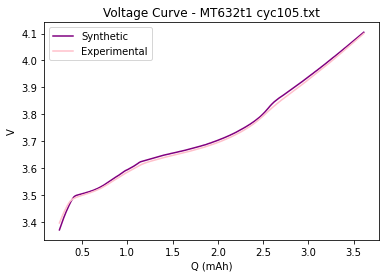

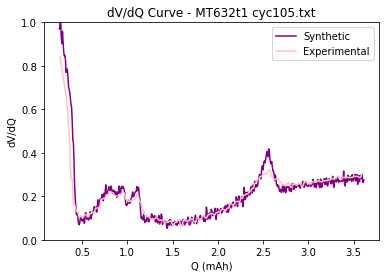

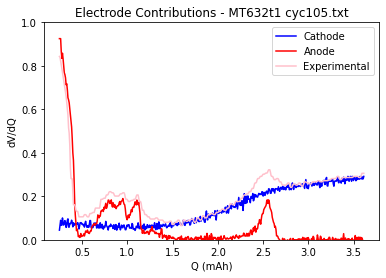

Optimized parameters for file: MT632t1 cyc156.txt [ 0.02367615  0.01448051 -0.49836882 -0.12636075]


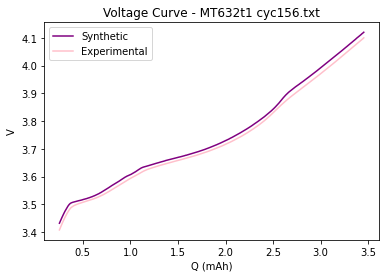

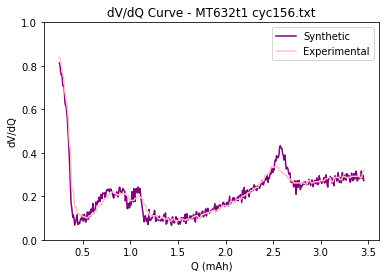

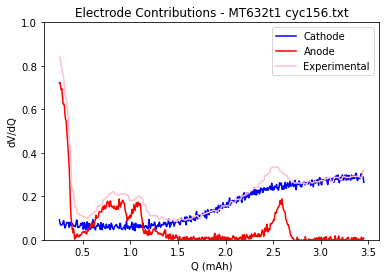

Optimized parameters for file: MT632t1 cyc207.txt [ 0.02327504  0.01372015 -0.53744643 -0.05482073]


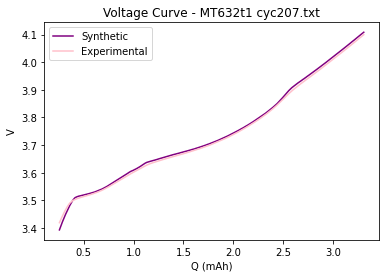

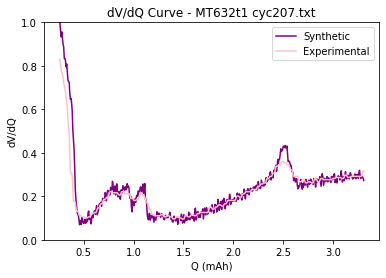

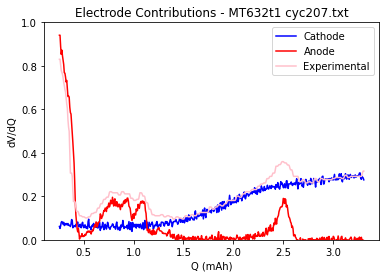

Optimized parameters for file: MT632t1 cyc258.txt [ 0.02241478  0.0136823  -0.49759437 -0.05928577]


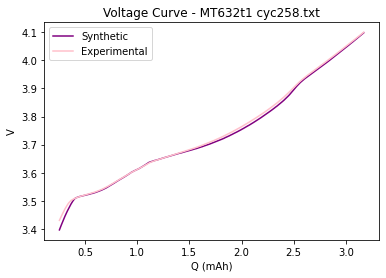

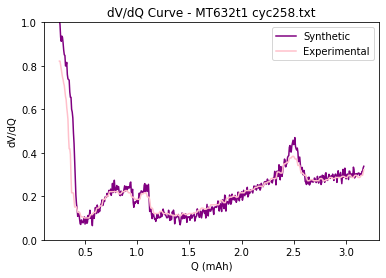

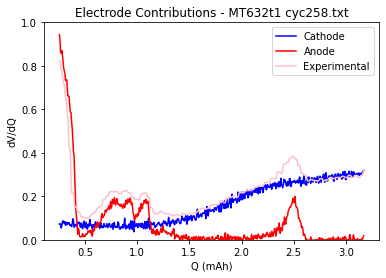

Optimized parameters for file: MT632t1 cyc3.txt [ 0.02694239  0.01343359 -0.53696242 -0.11115058]


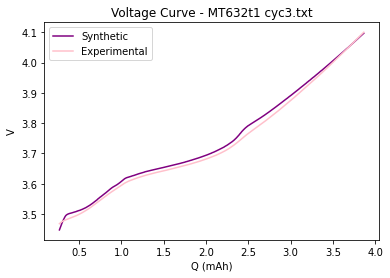

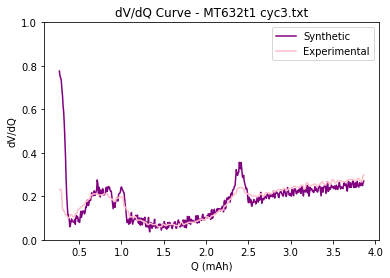

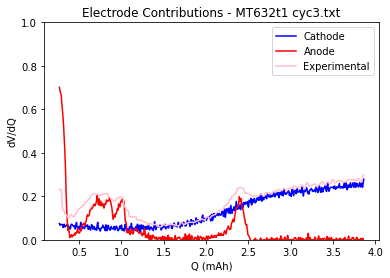

Optimized parameters for file: MT632t1 cyc309.txt [ 0.02234558  0.01359206 -0.56288904 -0.0631854 ]


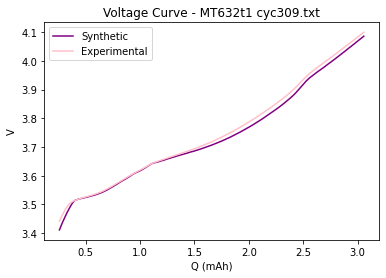

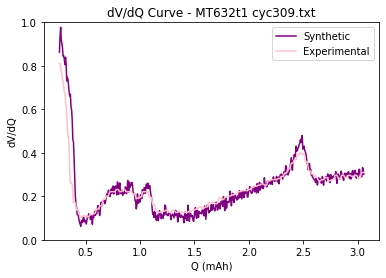

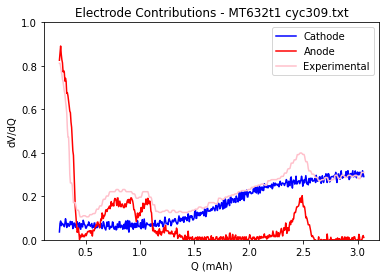

Optimized parameters for file: MT632t1 cyc54.txt [ 0.02397713  0.01396287 -0.19335053 -0.06373334]


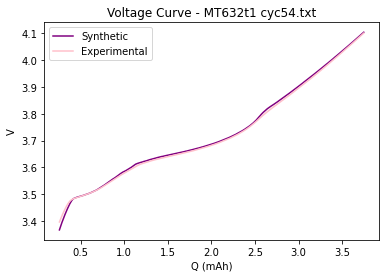

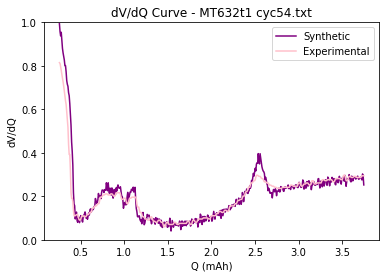

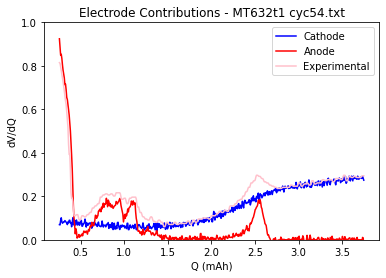

In [10]:
if os.path.isdir(electrode_path):
    results_dict = {}

    for data_file in os.listdir(electrode_path):
        file_path = os.path.join(electrode_path, data_file)

        if 'hc_nmc' in data_file:
            cathode_df = pd.read_csv(file_path, delimiter='\t')

        if 'hc_gr' in data_file:
            anode_df = pd.read_csv(file_path, delimiter='\t')

        if 'MT' in data_file:
            fullcell = os.path.basename(file_path)
            fullcell_df = pd.read_csv(file_path, delimiter='\t')

            # get cycle number from filename if available
            match = re.search(r'cyc(\d+)', fullcell)
            cycle = int(match.group(1)) if match else None

            try:
                result = minimize(
                    rmse,
                    io_guess,
                    args=(cathode_df, anode_df, fullcell_df),
                    bounds=bounds,
                    method='Powell',
                    options={'maxiter': 1000}
                )
            except StopIteration as e:
                print(str(e))
                continue

            print(f"Optimized parameters for file: {fullcell}", result.x)

            rmse_v, v_full_syn, v_full_data, dvdq_syn, dvdq_data, x_shared, dvdq_cathode_syn, dvdq_anode_syn = test_params(
                result.x, cathode_df, anode_df, fullcell_df, fullcell, 0.25, plot=True
            )

            results_dict[fullcell] = {
                "cycle": cycle,
                "rmse": rmse_v,
                "v_full_syn": v_full_syn,
                "v_full_data": v_full_data,
                "dvdq_syn": dvdq_syn,
                "dvdq_data": dvdq_data,
                "x_shared": x_shared,
                "dvdq_cathode_syn": dvdq_cathode_syn,
                "dvdq_anode_syn": dvdq_anode_syn,
                "optimized_params": result.x
            }